In [65]:
import sys

sys.path.append("../")

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [68]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [69]:
%config InlineBackend.figure_format = 'retina'

In [70]:
# EXPERIMENT_NAME = "runs_re2"
# DOMAIN = "re2"

EXPERIMENT_NAME = "runs_clevr"
DOMAIN = "clevr"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [71]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_clevr
Available domains: ['clevr']


## Runtime metrics

In [72]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime

Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_111/baseline_dreamcoder_96/6/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_111/baseline_dreamcoder_96/7/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_111/baseline_dreamcoder_96/8/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_111/baseline_dreamcoder_96/9/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/0/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/1/metrics.json
Not found: ../experiments_iterative/outputs/runs_clevr/domains/clevr/baseline_dreamcoder/seed_222/baseline_dreamcoder_96/2/metrics.json
Not found: ../experiments_iterative/outputs/runs

,curr_iteration,model_type,model_fn,task_split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration
0,0,grammar,infer_programs_for_tasks,train,2023-04-18 17:36:20.858154240+00:00,2023-04-18 17:46:22.391638272+00:00,601.533484,clevr,baseline_dreamcoder,111,0
1,0,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-18 17:46:22.392841984+00:00,2023-04-18 17:55:30.810768896+00:00,548.417927,clevr,baseline_dreamcoder,111,0
2,0,amortized_synthesis,infer_programs_for_tasks,train,2023-04-18 17:55:30.811285248+00:00,2023-04-18 18:05:41.405724928+00:00,610.594440,clevr,baseline_dreamcoder,111,0
3,0,amortized_synthesis,infer_programs_for_tasks,test,2023-04-18 18:05:41.407003136+00:00,2023-04-18 18:15:54.417990656+00:00,613.010988,clevr,baseline_dreamcoder,111,0
4,1,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-18 18:15:58.800224+00:00,2023-04-18 18:26:26.496545536+00:00,627.696321,clevr,baseline_dreamcoder,111,1
5,1,amortized_synthesis,infer_programs_for_tasks,train,2023-04-18 18:26:26.497700096+00:00,2023-04-18 18:36:49.674204160+00:00,623.176504,clevr,baseline_dreamcoder,111,1
6,2,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-18 18:37:06.534342144+00:00,2023-04-18 18:47:29.887197952+00:00,623.352856,clevr,baseline_dreamcoder,111,2
7,2,amortized_synthesis,infer_programs_for_tasks,train,2023-04-18 18:47:29.887976960+00:00,2023-04-18 18:58:02.801953280+00:00,632.913976,clevr,baseline_dreamcoder,111,2
8,3,amortized_synthesis,optimize_model_for_frontiers,train,2023-04-18 18:58:33.244471808+00:00,2023-04-18 19:08:49.107962880+00:00,615.863491,clevr,baseline_dreamcoder,111,3
9,3,amortized_synthesis,infer_programs_for_tasks,train,2023-04-18 19:08:49.108454912+00:00,2023-04-18 19:19:23.935217408+00:00,634.826762,clevr,baseline_dreamcoder,111,3


In [74]:
df_runtime.groupby(["domain", "experiment_type", "seed", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

domain  experiment_type      seed  model_type           model_fn                      task_split
clevr   baseline_dreamcoder  111   amortized_synthesis  infer_programs_for_tasks      test          625.481361
                                                                                      train         629.019356
                                                        optimize_model_for_frontiers  train         606.576761
                                   grammar              infer_programs_for_tasks      train         601.533484
Name: time_elapsed, dtype: float64

# Analysis 1: Tasks solved over time

### Tasks solved vs. LAPS iteration

In [75]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df

,request,task,programs,best_search_time,split,seed,iteration,experiment_type
0,"{'constructor': '->', 'arguments': [{'construc...",0-1_compare_integer-Is the number of large rub...,[],NaN,train,111,0,baseline_dreamcoder
1,"{'constructor': '->', 'arguments': [{'construc...",1-1_compare_integer-Is the number of metal sph...,[{'program': '(lambda (clevr_gt? 1 (clevr_coun...,0.000134,train,111,0,baseline_dreamcoder
2,"{'constructor': '->', 'arguments': [{'construc...",2-1_compare_integer-Is the number of cyan rubb...,[{'program': '(lambda (clevr_eq_material (clev...,0.000171,train,111,0,baseline_dreamcoder
3,"{'constructor': '->', 'arguments': [{'construc...",3-1_compare_integer-Is the number of large cyl...,[],NaN,train,111,0,baseline_dreamcoder
4,"{'constructor': '->', 'arguments': [{'construc...",4-1_compare_integer-Is the number of small yel...,[],NaN,train,111,0,baseline_dreamcoder
...,...,...,...,...,...,...,...,...
13927,"{'constructor': '->', 'arguments': [{'construc...",5-2_transform-If all of the cyan cylinders bec...,[],NaN,test,333,9,gpt_generation
13928,"{'constructor': '->', 'arguments': [{'construc...",6-2_transform-If all of the gray cubes became ...,[{'program': '(lambda (clevr_count (#(lambda (...,83.460032,test,333,9,gpt_generation
13929,"{'constructor': '->', 'arguments': [{'construc...",7-2_transform-If all of the large purple thing...,[],NaN,test,333,9,gpt_generation
13930,"{'constructor': '->', 'arguments': [{'construc...",8-2_transform-If all of the small rubber spher...,[{'program': '(lambda (#(lambda (lambda (clevr...,660.466438,test,333,9,gpt_generation


In [76]:
df_results = (
    df[df.programs.astype(bool)]
    .groupby(["experiment_type", "seed", "iteration", "split"])
    .task.count()
    .reset_index(name="n_solved")
)

df_results

,experiment_type,seed,iteration,split,n_solved
0,baseline_dreamcoder,111,0,test,43
1,baseline_dreamcoder,111,0,train,41
2,baseline_dreamcoder,111,1,train,97
3,baseline_dreamcoder,111,2,train,127
4,baseline_dreamcoder,111,3,test,86
...,...,...,...,...,...
79,gpt_generation,333,6,train,169
80,gpt_generation,333,7,train,172
81,gpt_generation,333,8,train,176
82,gpt_generation,333,9,test,96


Text(0.5, 1.0, 'clevr')

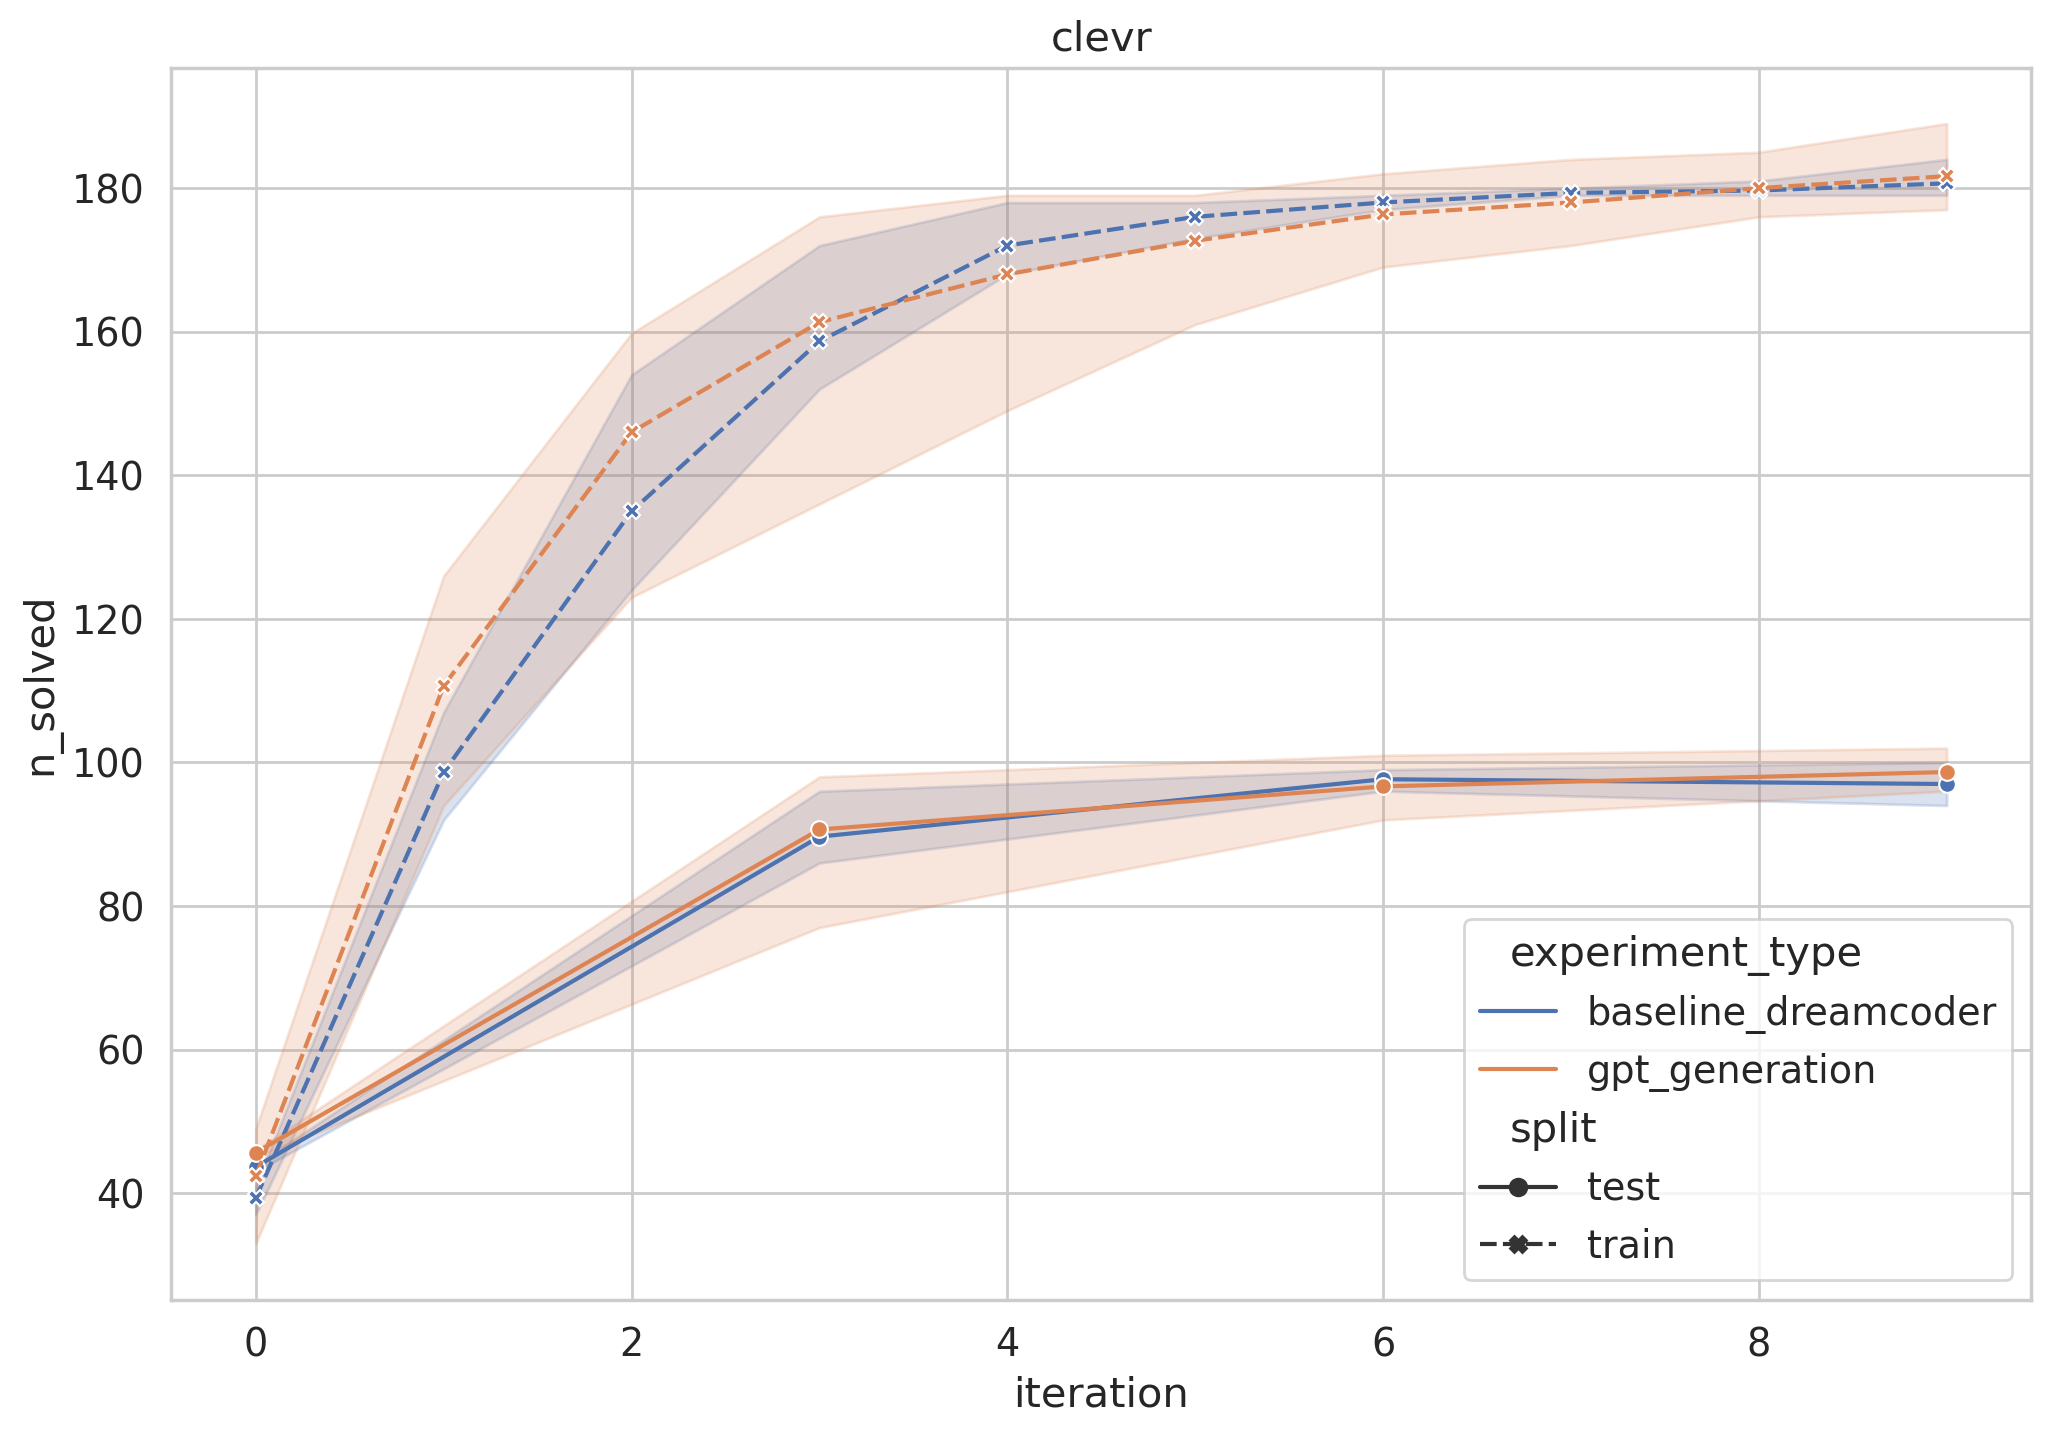

In [77]:
sns.lineplot(
    data=df_results, 
    x="iteration", 
    y="n_solved", 
    hue="experiment_type",
    style="split",
    markers=True,
)
plt.title(f"{DOMAIN}")

Text(0.5, 0.98, 'clevr')

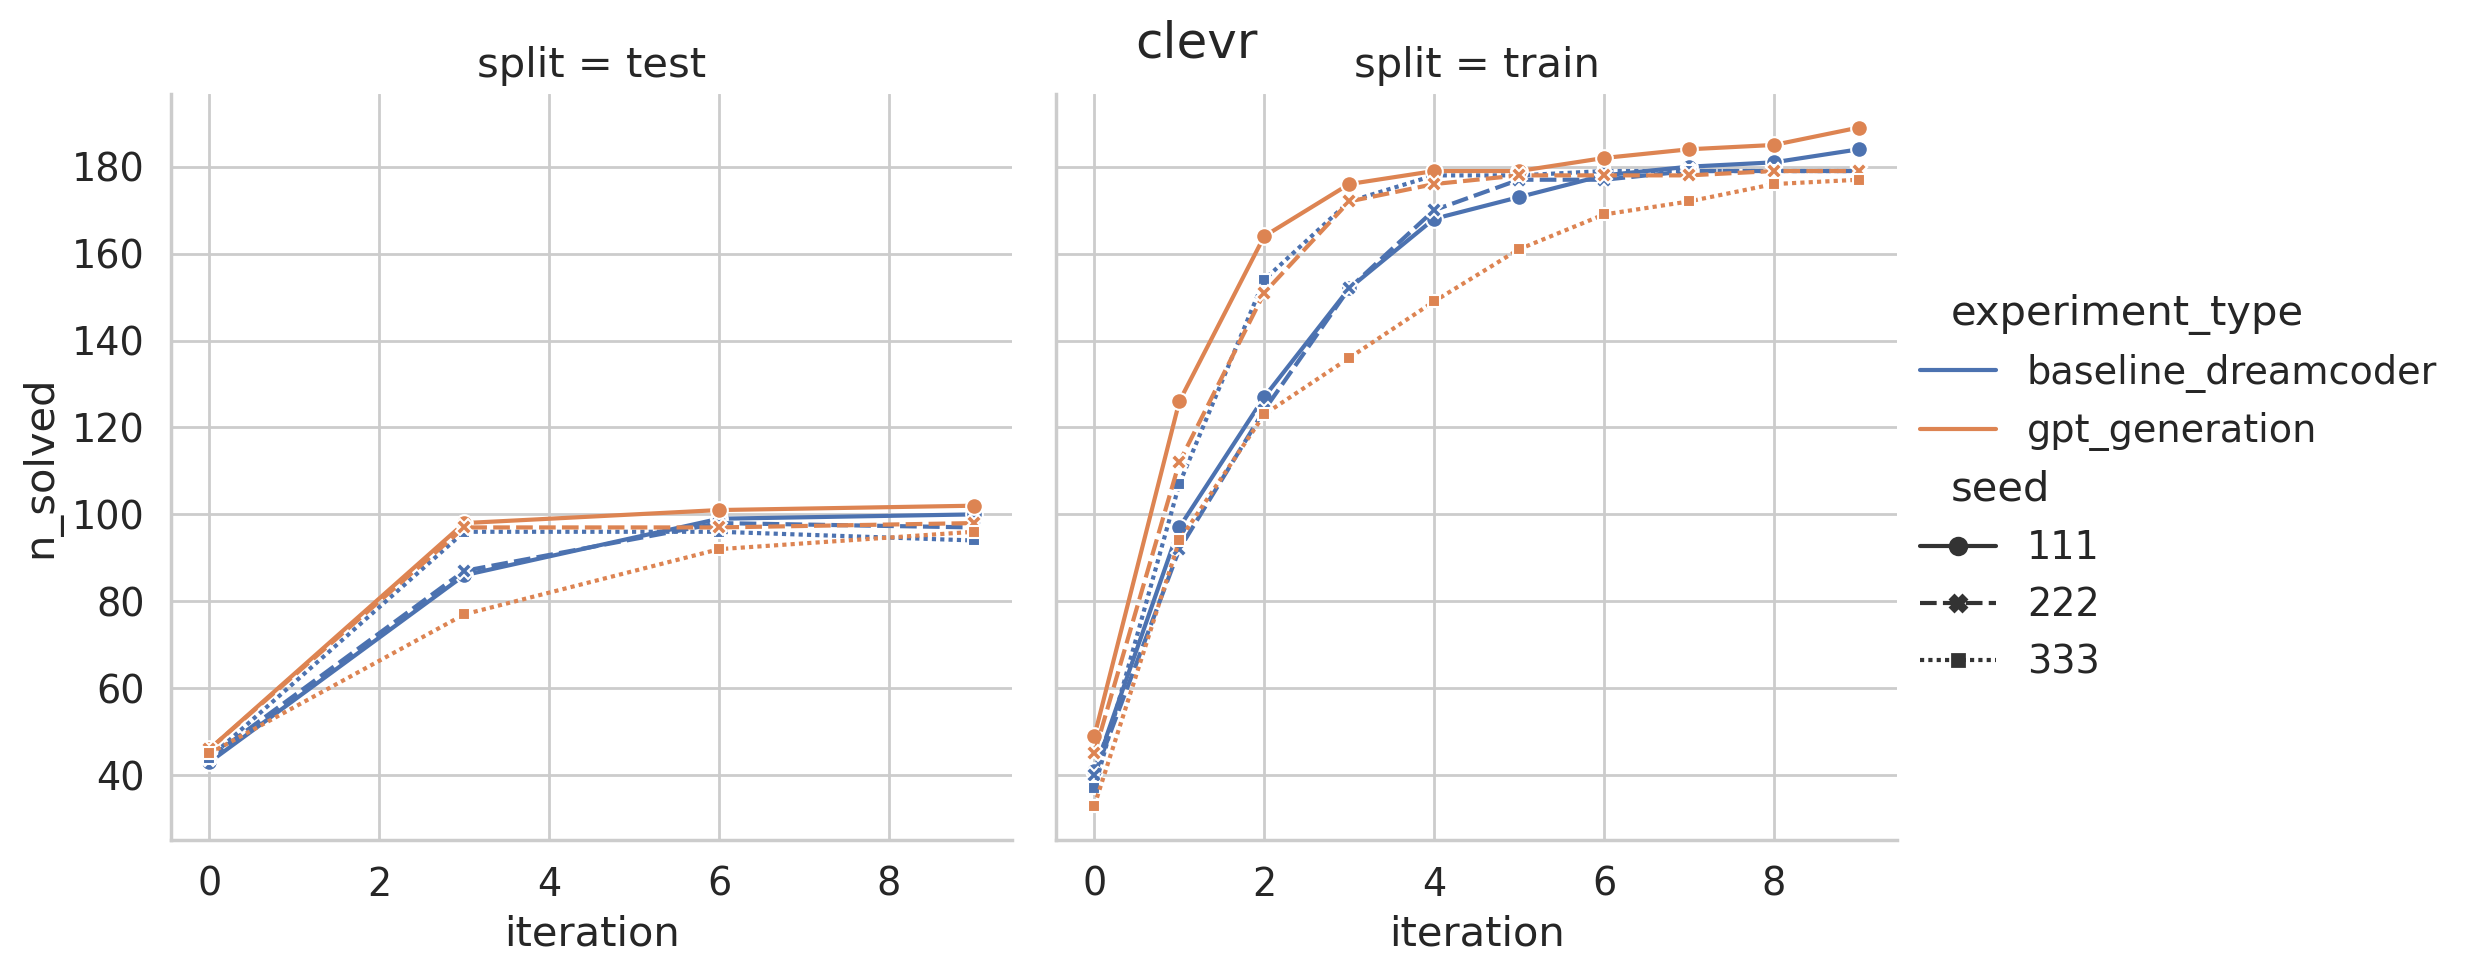

In [78]:
sns.relplot(
    data=df_results,
    kind="line",
    col="split",
    x="iteration", 
    y="n_solved", 
    hue="experiment_type",
    style="seed",
    markers=True,
)
plt.suptitle(f"{DOMAIN}")

### Tasks solved vs. search time

In [79]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

ValueError: Enumeration timeouts are inconsistent across conditions: [600, 1000, 1000, 1000, 1000, 1000]

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "train"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (train)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "train"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (train)")

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (test)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "test"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (test)")

# Analysis 2: Library abstractions

In [ ]:
df_abstractions = analyzer.get_abstractions_for_domain(DOMAIN)
df_abstractions.to_csv(f"{DOMAIN}_abstractions.csv", index=False)
df_abstractions

In [ ]:
ax = sns.relplot(data=df_abstractions.query("random_seed == 111").sort_values(by=["dreamcoder"], key=lambda x: x.str.len()), kind="line", col="experiment_type", y="dreamcoder", x="iteration", hue="name", size="name")
ax.set(yticklabels=[])
plt.show()

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(df_abstractions.sort_values(["experiment_type", "random_seed", "name", "iteration"])[["experiment_type", "random_seed", "name", "iteration", "arity", "compression_ratio", "dreamcoder"]])

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="compression_ratio", size="iteration")

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.title(f"{DOMAIN} compressivity of library")

In [ ]:
sns.relplot(data=df_abstractions, kind="line", errorbar="se", col="experiment_type", x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.suptitle(f"{DOMAIN} compressivity of library")

# Analysis 3: Solved programs

In [ ]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df.to_csv(f"{DOMAIN}_search_results.csv")

# re2-specific analysis

In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def task_order(keys):
    return [int(re.split(r'(\d+)', k[len("re2_test_"):])[1]) for k in keys]

def alpha_order(keys):
    return [re.split(r'(\d+)', k[len("re2_test_"):])[-1] for k in keys]

In [ ]:
df_solved_i3 = df[~pd.isnull(df.best_search_time)].query("split == 'test'").query("iteration == 6").query("seed == 111")

In [ ]:
df_solved_sorted = df_solved_i3[["task", "experiment_type", "best_search_time"]].pivot(index="task", columns=["experiment_type"]).sort_index(key=alpha_order)
df_solved_sorted = df_solved_sorted.reset_index(level=0)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(df_solved_sorted)